# Apartment price prediction with Keras and Torch

## Libraries and settings

In [28]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

## Import the apartment data

In [29]:
# Read and select variables
df_orig = pd.read_csv("apartments_data_enriched_with_new_features.csv", sep=",", encoding='utf-8')

# Remove missing values
df = df_orig.dropna()
# Remove duplicates
df = df.drop_duplicates()

print(df.shape)
df.head(10)

(2344, 45)


,Unnamed: 0,bfs_number,rooms,area,price,postalcode,address,town,description_raw,bfs_name,...,Kreis 10,Kreis 4,Kreis 1,Kreis 9,Kreis 5,Kreis 7,Kreis 3,Kreis 2,Kreis 8,zurich_city
0,0,261,4.5,148,4180,8050,"Schaffhauserstrasse 363, 8050 Zürich",Zürich,««Renovierte 4.5-Zimmerwohnung an zentraler La...,Zürich,...,0,0,0,0,0,0,0,0,0,1
1,1,261,2.0,122,3190,8050,"Max Bill Platz 5, 8050 Zürich",Zürich,«Modernes Wohnen im Zentrum von Oerlikon»,Zürich,...,0,0,0,0,0,0,0,0,0,1
2,2,261,3.5,78,2780,8050,"Regensbergstrasse 30, 8050 Zürich",Zürich,«Wohnen am Puls von Zürich»,Zürich,...,0,0,0,0,0,0,0,0,0,1
3,3,261,3.5,69,3750,8050,"Dörflistrasse 112, 8050 Zürich",Zürich,"«Trendy Oerlikon 3.5 Room w/ Balcony, 1min to ...",Zürich,...,0,0,0,0,0,0,0,0,0,1
4,4,261,3.5,74,2390,8050,"Schaffhauserstrasse 445, 8050 Zürich",Zürich,«Helle und zentrale Wohnung in Zürich-Oerlikon»,Zürich,...,0,0,0,0,0,0,0,0,0,1
5,5,261,4.5,98,3800,8050,"Eggbühlstrasse 9, 8050 Zürich",Zürich,«An bester Wohnlage in Zürich-Oerlikon»,Zürich,...,0,0,0,0,0,0,0,0,0,1
6,6,261,2.5,60,2460,8050,"Leutschenbachstrasse 46, 8050 Zürich",Zürich,"«Schicke Oerlikon 2.5ZW mit Keller und W/T, na...",Zürich,...,0,0,0,0,0,0,0,0,0,1
7,7,261,2.5,64,2640,8050,"Siewerdtstrasse 19, 8050 Zürich",Zürich,«Erstvermietung - Stilvoll wohnen im Herzen vo...,Zürich,...,0,0,0,0,0,0,0,0,0,1
8,8,261,3.5,92,4210,8050,"Siewerdtstrasse 19, 8050 Zürich",Zürich,«Attikawohnung Erstvermietung - Stilvoll wohne...,Zürich,...,0,0,0,0,0,0,0,0,0,1
9,9,261,3.5,85,3130,8050,"Siewerdtstrasse 19, 8050 Zürich",Zürich,«Erstvermietung - Stilvoll wohnen im Herzen vo...,Zürich,...,0,0,0,0,0,0,0,0,0,1


In [30]:


# Meaning of variables:
# bfs_number: official municipality id
# bfs_name: official municipality name
# pop: number of residents (=population)
# pop_dens: population density (pop per km2)
# frg_pct: percentage foreigners
# emp: numer of employees


df = df[['rooms', 'area', 'price', 'postalcode',
       'address', 'town', 'description_raw', 'bfs_name', 'pop', 'pop_dens',
       'frg_pct', 'emp', 'tax_income', 'lat', 'lon', 'x', 'y', 'room_per_m2',
       'luxurious', 'temporary', 'furnished', 'area_cat',
       'area_cat_ecoded', '(LOFT)', '(POOL)', '(ATTIKA)', '(EXKLUSIV)',
       '(SEESICHT)', '(LUXURIÖS)', 'Kreis 6', 'Kreis 11', 'Kreis 12',
       'Kreis 10', 'Kreis 4', 'Kreis 1', 'Kreis 9', 'Kreis 5', 'Kreis 7',
       'Kreis 3', 'Kreis 2', 'Kreis 8', 'zurich_city',]]
df.columns



Index(['rooms', 'area', 'price', 'postalcode', 'address', 'town',
       'description_raw', 'bfs_name', 'pop', 'pop_dens', 'frg_pct', 'emp',
       'tax_income', 'lat', 'lon', 'x', 'y', 'room_per_m2', 'luxurious',
       'temporary', 'furnished', 'area_cat', 'area_cat_ecoded', '(LOFT)',
       '(POOL)', '(ATTIKA)', '(EXKLUSIV)', '(SEESICHT)', '(LUXURIÖS)',
       'Kreis 6', 'Kreis 11', 'Kreis 12', 'Kreis 10', 'Kreis 4', 'Kreis 1',
       'Kreis 9', 'Kreis 5', 'Kreis 7', 'Kreis 3', 'Kreis 2', 'Kreis 8',
       'zurich_city'],
      dtype='object')

In [31]:
# Create train and test samples
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded', 'zurich_city']

X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                         df['price'], 
                                                        test_size=0.20, 
                                                        random_state=42)

<hr >

## Sklearn

### RandomForestRegressor

In [32]:
# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(X_train, y_train)
print("Train score: ", random_forest_model.score(X_train, y_train))
print("Test score: ", random_forest_model.score(X_test, y_test))

print("Train RMSE: ", root_mean_squared_error(y_train, random_forest_model.predict(X_train)))
print("Test RMSE: ", root_mean_squared_error(y_test, random_forest_model.predict(X_test)))

Train score:  0.9437123170192876
Test score:  0.6580388522714511
Train RMSE:  255.7095825812701
Test RMSE:  638.1863870741726


### MLPRegressor

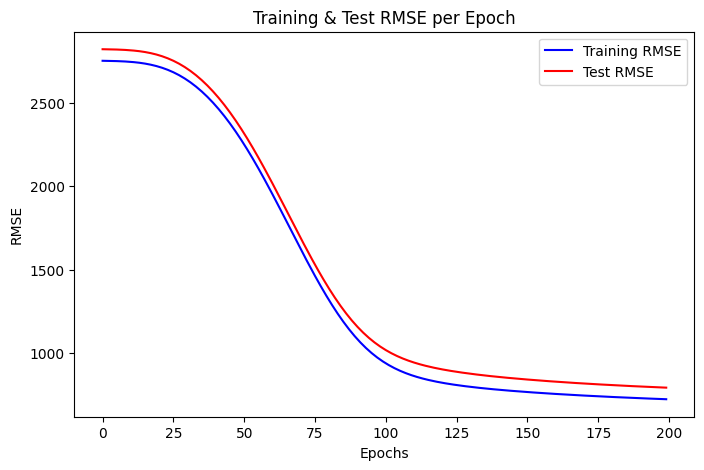

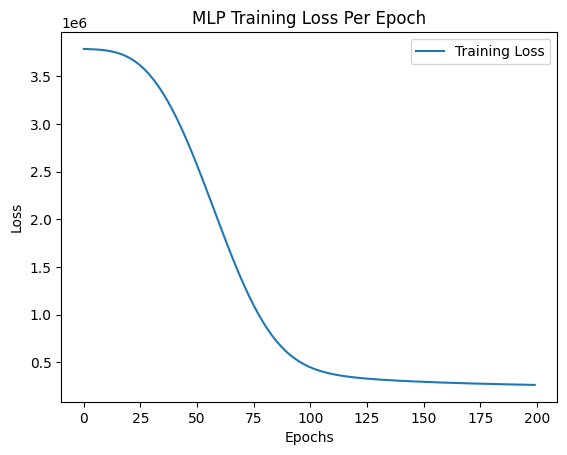

In [33]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(df[features], df['price'], 
                                                    test_size=0.20, random_state=42)


# Standardizing the features (MLP performs better with standardized data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the MLP model
mlp = MLPRegressor(hidden_layer_sizes=(16, 16), activation='relu',
                   solver='adam', max_iter=200, random_state=42,
                   verbose=False, validation_fraction=0.1)

# Store training and validation RMSE per epoch
train_rmse = []
val_rmse = []

for i in range(1, mlp.max_iter + 1):
    mlp.partial_fit(X_train_scaled, y_train)

    # Training RMSE
    y_train_pred = mlp.predict(X_train_scaled)
    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    
    # Validation RMSE
    y_val_pred = mlp.predict(X_test_scaled)
    val_rmse.append(np.sqrt(mean_squared_error(y_test, y_val_pred)))

# Plot RMSE per epoch
plt.figure(figsize=(8, 5))
plt.plot(train_rmse, label="Training RMSE", color='blue')
plt.plot(val_rmse, label="Test RMSE", color='red')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Training & Test RMSE per Epoch")
plt.legend()
plt.show()

# Plot loss curve
plt.plot(mlp.loss_curve_, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("MLP Training Loss Per Epoch")
plt.legend()
plt.show()

<hr >

## Pytourch

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define Regression Model
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# PyTorch Regression Function with Graphics
def pytorch_regression_model(features, df):
    df = df.sample(frac=1, random_state=42)  # Shuffle dataset
    X, y = df[features].values, df['price'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    model = RegressionModel(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    num_epochs = 10000
    train_losses = []
    test_losses = []
    train_rmse = []
    test_rmse = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train)
        loss = criterion(predictions, y_train)
        loss.backward()
        optimizer.step()

        # Store losses for visualization
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                train_predictions = model(X_train)
                train_loss = criterion(train_predictions, y_train).item()
                
                test_predictions = model(X_test)
                test_loss = criterion(test_predictions, y_test).item()
                
            train_losses.append(loss.item())
            test_losses.append(test_loss)
            train_rmse.append(np.sqrt(train_loss))
            test_rmse.append(np.sqrt(test_loss))

    with torch.no_grad():
        train_predictions = model(X_train)
        train_loss = criterion(train_predictions, y_train).item()
        test_predictions = model(X_test)
        test_loss = criterion(test_predictions, y_test).item()

    print("Train Loss (RMSE):", np.sqrt(train_loss))
    print("Test Loss (RMSE):", np.sqrt(test_loss))
        
    # Plot Loss over Epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(0, num_epochs, 10), train_losses, label='Train Loss', color='blue')
    plt.plot(range(0, num_epochs, 10), test_losses, label='Test Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('Training & Testing Loss Over Epochs')
    plt.legend()
    plt.show()
    

    # Plot train test rmse over Epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(0, num_epochs, 10), train_rmse, label='Train RMSE', color='blue')
    plt.plot(range(0, num_epochs, 10), test_rmse, label='Test RMSE', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.title('Training & Testing RMSE Epochs')
    plt.legend()
    plt.show()
    
    # Convert losses to RMSE
    train_rmse = np.sqrt(train_losses)
    test_rmse = np.sqrt(test_losses)

    # Define starting epoch
    starting_epoch = 400
    start_index = starting_epoch // 10  # Adjust indexing to match collected RMSE points

    # Slice RMSE lists and epochs accordingly
    train_rmse_filtered = train_rmse[start_index:]
    test_rmse_filtered = test_rmse[start_index:]
    epochs_filtered = range(starting_epoch, num_epochs, 10)  # Match RMSE data points

    # Plot RMSE from epoch 400 onwards
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_filtered, train_rmse_filtered, label='Train RMSE', color='blue')
    plt.plot(epochs_filtered, test_rmse_filtered, label='Test RMSE', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.title(f'Training & Testing RMSE from Epoch {starting_epoch}')
    plt.legend()
    plt.show()
    
    # Scatter Plot of Predictions vs Actual
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test.numpy(), test_predictions.numpy(), color='blue', alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Diagonal line
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs Predicted Prices')
    plt.show()

Train Loss (RMSE): 590.0451783550137
Test Loss (RMSE): 813.5807427661989


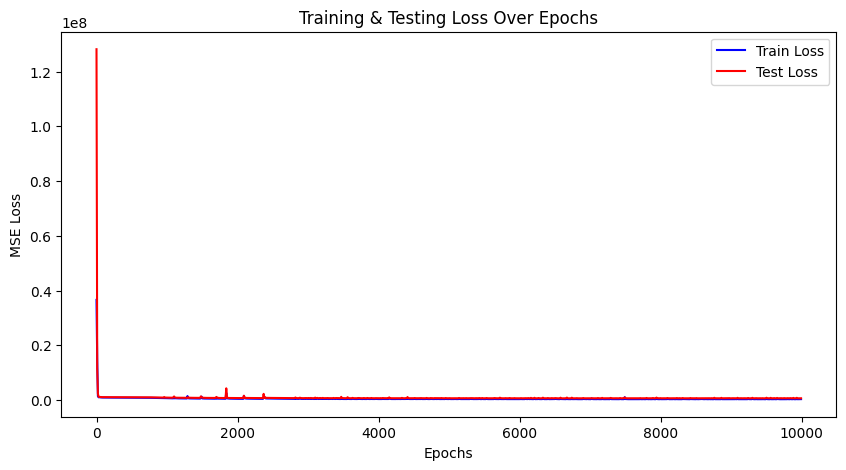

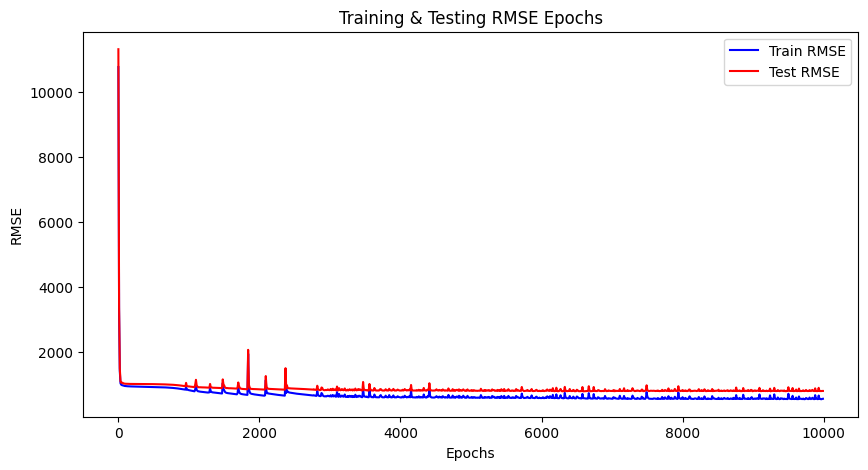

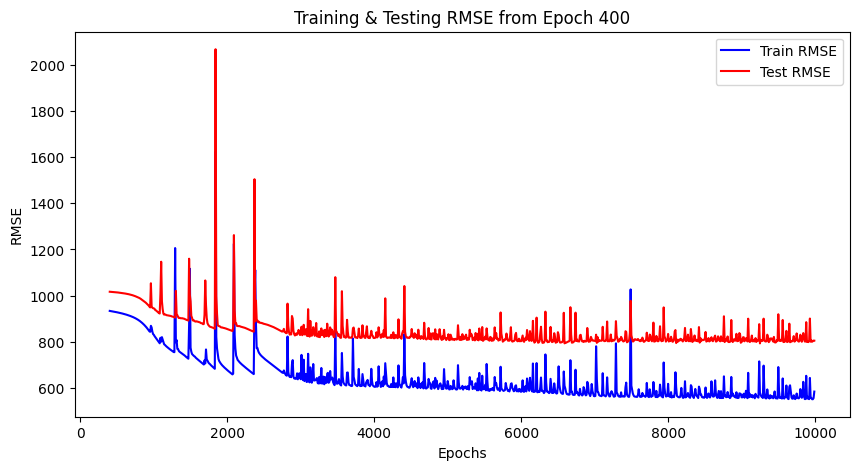

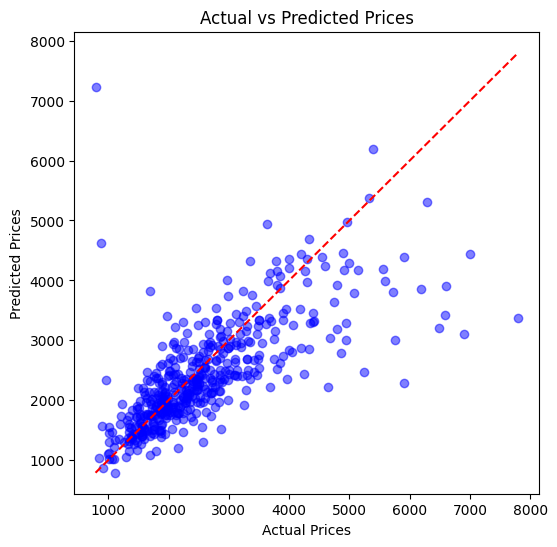

In [36]:
pytorch_regression_model(features, df)